In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from fastai import *
from fastai.tabular import *
from fastai.callbacks import *
from fastai.text import *
from fastai.data_block import *
from fastai.metrics import *
from sklearn.model_selection import StratifiedKFold
from swallows.training import *
from swallows.models import *
import time
from IPython.display import FileLink, FileLinks
from swallows.plots import *
from sklearn.model_selection import *
from swallows.models_ensemble_v4 import *

In [3]:
path=Path('data')

In [4]:
model_name = 'ensemble-v5'

In [5]:
nlp_details_model_name = 'details-100k'
nlp_descr_model_name = 'short_description-60k'
nlp_details_encoder_name = f'{nlp_details_model_name}-tuned-enc'
nlp_descr_encoder_name = f'{nlp_descr_model_name}-tuned-enc'
tab_model_name = f'tab-v4-stage-6-fitted'

In [6]:
bs = 256

# Data Packaging

In [7]:
df_raw = pd.read_parquet(path/'processed/training_stage_4.parquet', engine='fastparquet')
df_raw_test = pd.read_parquet(path/'processed/public_test_features_stage_4.parquet', engine='fastparquet')
df_raw_6 = pd.read_parquet(path/'processed/training_stage_6.parquet', engine='fastparquet')
df_raw_test_6 = pd.read_parquet(path/'processed/public_test_features_stage_6.parquet', engine='fastparquet')

In [8]:
df_train = df_raw.join(df_raw_6)
df_test = df_raw_test.join(df_raw_test_6)

In [9]:
cont_names = [col for col in df_train.columns if '_ratio' in col]

exclude_from_cats = [
    'ID', 
    'assigned_date',
    'create_date',
    'details',
    'short_description',
    'amazon_domains',
    'root_cause',
    'create_to_assigned_lag'
    'create_to_assigned_lag_log',
    'assigned_date_Elapsed'
    'create_date_Elapsed',
] + cont_names

cat_names = [c for c in df_raw.columns if c not in exclude_from_cats]
dep_var = 'root_cause'
procs = [FillMissing, Categorify, Normalize]

In [12]:
large_cats = remove_targets_with_low_frequency(df_train, 'root_cause', min_cat_size=30)

Total cats: 960 with 1156151 items
cats w/ >30 items: 276 with 99.67% coverage


In [14]:
train_data = df_train[df_train['root_cause'].isin(large_cats.reset_index()['root_cause'])]

In [17]:
split = train_test_split(range(len(train_data)), random_state=42, test_size=0.035, stratify=train_data['root_cause'])

In [18]:
data_details_lm = load_data(path, f'data-lm-{nlp_details_model_name}.pkl', bs=bs)
vocab_details = data_details_lm.vocab

data_descr_lm = load_data(path, f'data-lm-{nlp_descr_model_name}.pkl', bs=bs)
vocab_descr = data_descr_lm.vocab

In [19]:
list_tab = TabularList.from_df(train_data[cat_names + cont_names + [dep_var]], cat_names=cat_names, cont_names=cont_names, procs=procs, path=path)
list_text_details = TextList.from_df(train_data[['details']], cols='details', path=path, vocab=vocab_details)
list_text_descr = TextList.from_df(train_data[['short_description']], cols='short_description', path=path, vocab=vocab_descr)

#### Create mixed databunch

In [10]:
# data_text_descr = (TextList.from_df(train_data[['short_description','root_cause']], cols='short_description', path=path, vocab=vocab_descr)
#                 .split_by_idxs(split[0], split[1])
#                 .label_from_df(cols=dep_var)
#                 .databunch(bs=bs))
# data_text_descr.save(f'{model_name}_data_text_descr')

data_text_descr = load_data(path, f'{model_name}_data_text_descr', bs=bs)

In [11]:
# data_text_details = (TextList.from_df(train_data[['details','root_cause']], cols='details', path=path, vocab=vocab_details)
#                 .split_by_idxs(split[0], split[1])
#                 .label_from_df(cols=dep_var)
#                 .databunch(bs=bs))
# data_text_details.save(f'{model_name}_data_text')

data_text_details = load_data(path, f'{model_name}_data_text', bs=bs)

In [12]:
# data_tab = (TabularList.from_df(train_data, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
#                            .split_by_idxs(split[0], split[1])
#                            .label_from_df(cols=dep_var)
#                            .databunch(bs=bs))
# data_tab.save(f'{model_name}_data_tab')

data_tab = load_data(path, f'{model_name}_data_tab', bs=bs)

In [10]:
sources = [data_tab, data_text_descr, data_text_details]

In [11]:
data = mixed_data_bunch_v4(path, *sources, bs)
classes = data.train_ds.classes

In [27]:
len(data_text_details.vocab.itos), len(data_text_descr.vocab.itos)

(100004, 41642)

# Training

#### Load models

In [18]:
def build_learner(data):
    tab_model, tab_layer_groups = load_tabular_backbone(sources[0], tab_model_name)
    nlp_descr_model, nlp_dsc_layer_groups = load_nlp_backbone_pretrained(sources[1], f'nlp-classifier-{nlp_descr_model_name}-final', drop_mult=0.0)
    nlp_details_model, nlp_det_layer_groups = load_nlp_backbone_pretrained(sources[2], f'nlp-classifier-{nlp_details_model_name}-final', drop_mult=0.0)
    
    len_nlp_det_out = nlp_details_model[1].layers[1].out_features
    len_nlp_desc_out = nlp_descr_model[1].layers[1].out_features
    len_tab_out = tab_model.layers[4].out_features

    lin_layers = [len_nlp_det_out + len_nlp_desc_out + len_tab_out, len(sources[0].classes)]
    model = EnsembleModelV4(tab_model, nlp_descr_model, nlp_details_model, layers=lin_layers, drops=[0.2])
    layer_groups = [
        nn.Sequential(*(flatten_model(nlp_det_layer_groups[0]) + flatten_model(nlp_dsc_layer_groups[0]) + flatten_model(tab_layer_groups[0]))),
        nn.Sequential(*(flatten_model(nlp_det_layer_groups[1]) + flatten_model(nlp_dsc_layer_groups[1]))),
        nn.Sequential(*(flatten_model(nlp_det_layer_groups[2]) + flatten_model(nlp_dsc_layer_groups[2]))),
        nn.Sequential(*(flatten_model(nlp_det_layer_groups[3]) + flatten_model(nlp_dsc_layer_groups[3]))),
        nn.Sequential(*(flatten_model(nlp_det_layer_groups[4]) + flatten_model(nlp_dsc_layer_groups[4]))),
        nn.Sequential(*flatten_model(model.layers))]
    
    learn = Learner(data, model, metrics=accuracy_v2, layer_groups=layer_groups)
    return learn

#### Training

In [33]:
learn = build_learner(data)
learn.freeze()

epoch,train_loss,valid_loss,accuracy_v2,time
0,1.164734,1.256984,0.619127,14:29


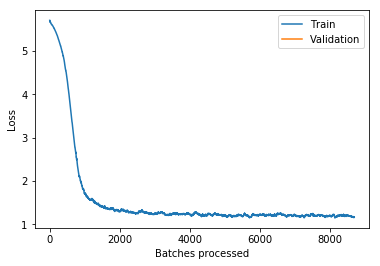

In [35]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7)); learn.recorder.plot_losses()

In [36]:
learn.save(f'{model_name}-1')

In [38]:
learn.unfreeze()
callbacks = SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy_v2', name=f'{model_name}-final')
learn.fit_one_cycle(3, slice(1e-4/(2.6**4),1e-4), moms=(0.8, 0.7), callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy_v2,time
0,1.142445,1.377371,0.620193,37:18
1,1.135800,1.256413,0.621358,35:41
2,1.119296,1.245978,0.624086,38:01


Better model found at epoch 0 with accuracy_v2 value: 0.6201928853988647.
Better model found at epoch 1 with accuracy_v2 value: 0.6213582754135132.
Better model found at epoch 2 with accuracy_v2 value: 0.6240856647491455.


Public leaderboard score: 0.617165899083

# Predict

In [13]:
df_raw_test = pd.read_parquet(path/'processed/public_test_features_stage_4.parquet', engine='fastparquet')
df_raw_test_6 = pd.read_parquet(path/'processed/public_test_features_stage_6.parquet', engine='fastparquet')

In [14]:
df_test = df_raw_test.join(df_raw_test_6)
df_test_ids = pd.read_csv(path/'public_test_features_IDs.csv', low_memory=False)

In [15]:
data_text_details.add_test(TextList.from_df(df_test[['details']], path, vocab=data_text_details.vocab))
data_text_descr.add_test(TextList.from_df(df_test[['short_description']], path, vocab=data_text_descr.vocab))
data_tab.add_test(TabularList.from_df(df_test[cat_names + cont_names], path=path, cat_names=cat_names, cont_names=cont_names, procs=procs))

In [16]:
sources = [data_tab, data_text_descr, data_text_details]
data_test = mixed_data_bunch_v4(path, *sources, bs)

In [19]:
learn_test = build_learner(data_test)
learn_test.load(f'{model_name}-final')

Learner(data=DataBunch;

Train: <swallows.models_ensemble_v4.EnsembleDatasetV4 object at 0x7f20632e4c88>;

Valid: <swallows.models_ensemble_v4.EnsembleDatasetV4 object at 0x7f20632e4ef0>;

Test: <swallows.models_ensemble_v4.EnsembleDatasetV4 object at 0x7f20632e4b00>, model=EnsembleModelV4(
  (tab_model): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(454, 49)
      (1): Embedding(8, 5)
      (2): Embedding(100, 21)
      (3): Embedding(6, 4)
      (4): Embedding(1642, 101)
      (5): Embedding(5, 4)
      (6): Embedding(3, 3)
      (7): Embedding(1115, 81)
      (8): Embedding(2278, 121)
      (9): Embedding(36, 12)
      (10): Embedding(1084, 80)
      (11): Embedding(34, 12)
      (12): Embedding(1892, 109)
      (13): Embedding(6, 4)
      (14): Embedding(311, 40)
      (15): Embedding(569, 56)
      (16): Embedding(35, 12)
      (17): Embedding(3, 3)
      (18): Embedding(3, 3)
      (19): Embedding(3, 3)
      (20): Embedding(3, 3)
      (21): Embedding(3, 3)
      

In [20]:
learn_test.validate()

[1.2459778, tensor(0.6241)]

In [21]:
preds,y = learn_test.get_preds(ds_type=DatasetType.Test)

In [22]:
pred_classes = [data_test.classes[cls] for cls in np.argmax(preds.numpy(), axis=1)]

In [23]:
df_out = pd.DataFrame({'ID': df_test_ids['ID'], 'root_cause': pred_classes})

In [25]:
t = time.strftime('%Y_%m_%d_%H_%M')
out_fname = path/f'mle_ops_tech_{t}_{model_name}.csv'
df_out.to_csv(out_fname, index=False)
FileLink(out_fname)

/home/ec2-user/2019-ops-it-challenge/data/mle_ops_tech_2019_05_11_08_56_ensemble-v5.csv

public leaderboard: 0.617165899083

# Interpretation

In [45]:
preds,y = learn_test.get_preds(ds_type=DatasetType.Valid)

In [46]:
pred_classes = [data_test.classes[cls] for cls in np.argmax(preds.numpy(), axis=1)]

In [47]:
actl_classes = [data_test.classes[cls] for cls in y]

In [48]:
df_out_val = df_train.iloc[split[1]].copy()
df_out_val['predicted_root_cause'] = pred_classes

In [49]:
t = time.strftime('%Y_%m_%d_%H_%M')
out_fname = path/f'mle_ops_tech_{t}_{model_name}-val-set.csv'
df_out_val.to_csv(out_fname, index=False)
FileLink(out_fname)

/home/ec2-user/2019-ops-it-challenge/data/mle_ops_tech_2019_05_04_06_47_ensemble-v4-100k-val-set.csv

In [50]:
from sklearn.metrics import confusion_matrix

In [51]:
cnf_matrix = confusion_matrix(y, np.argmax(preds.numpy(), axis=1))

Normalized confusion matrix


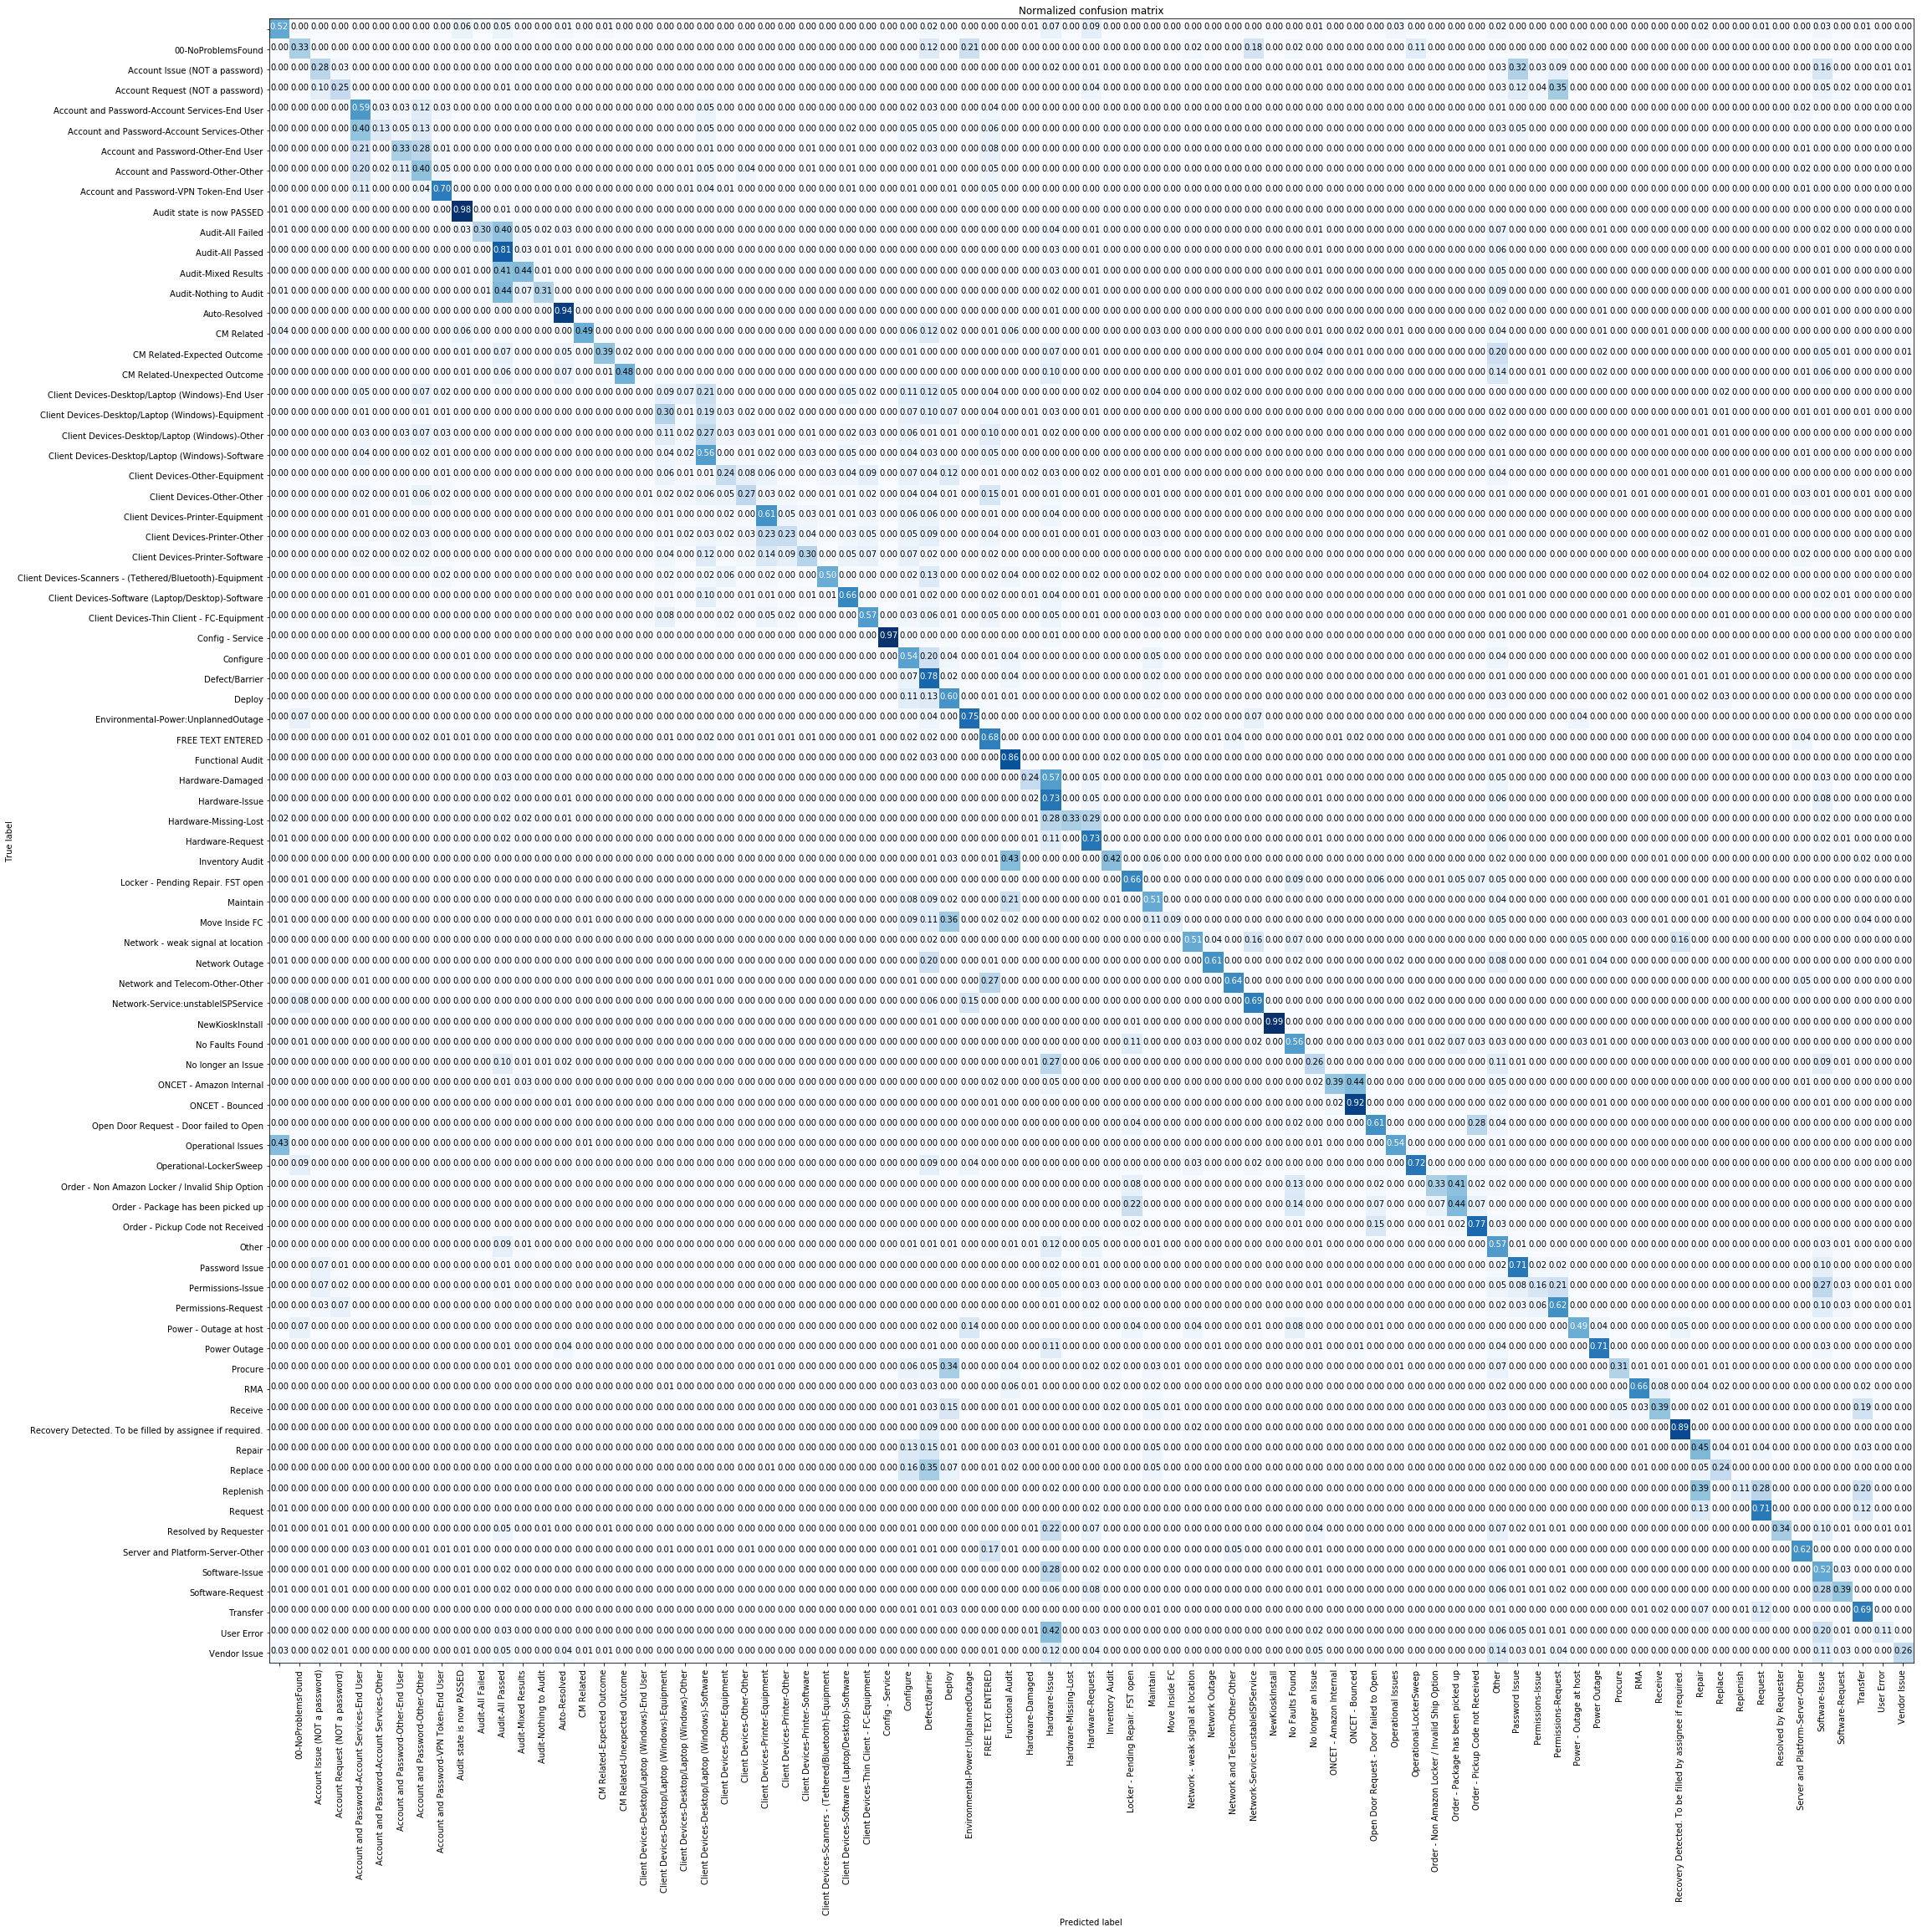

In [52]:
fig = plt.figure()
fig.set_size_inches(32, 32, forward=True)
plot_confusion_matrix(cnf_matrix, classes=data_test.classes, normalize=True, title='Normalized confusion matrix')

Confusion matrix, without normalization


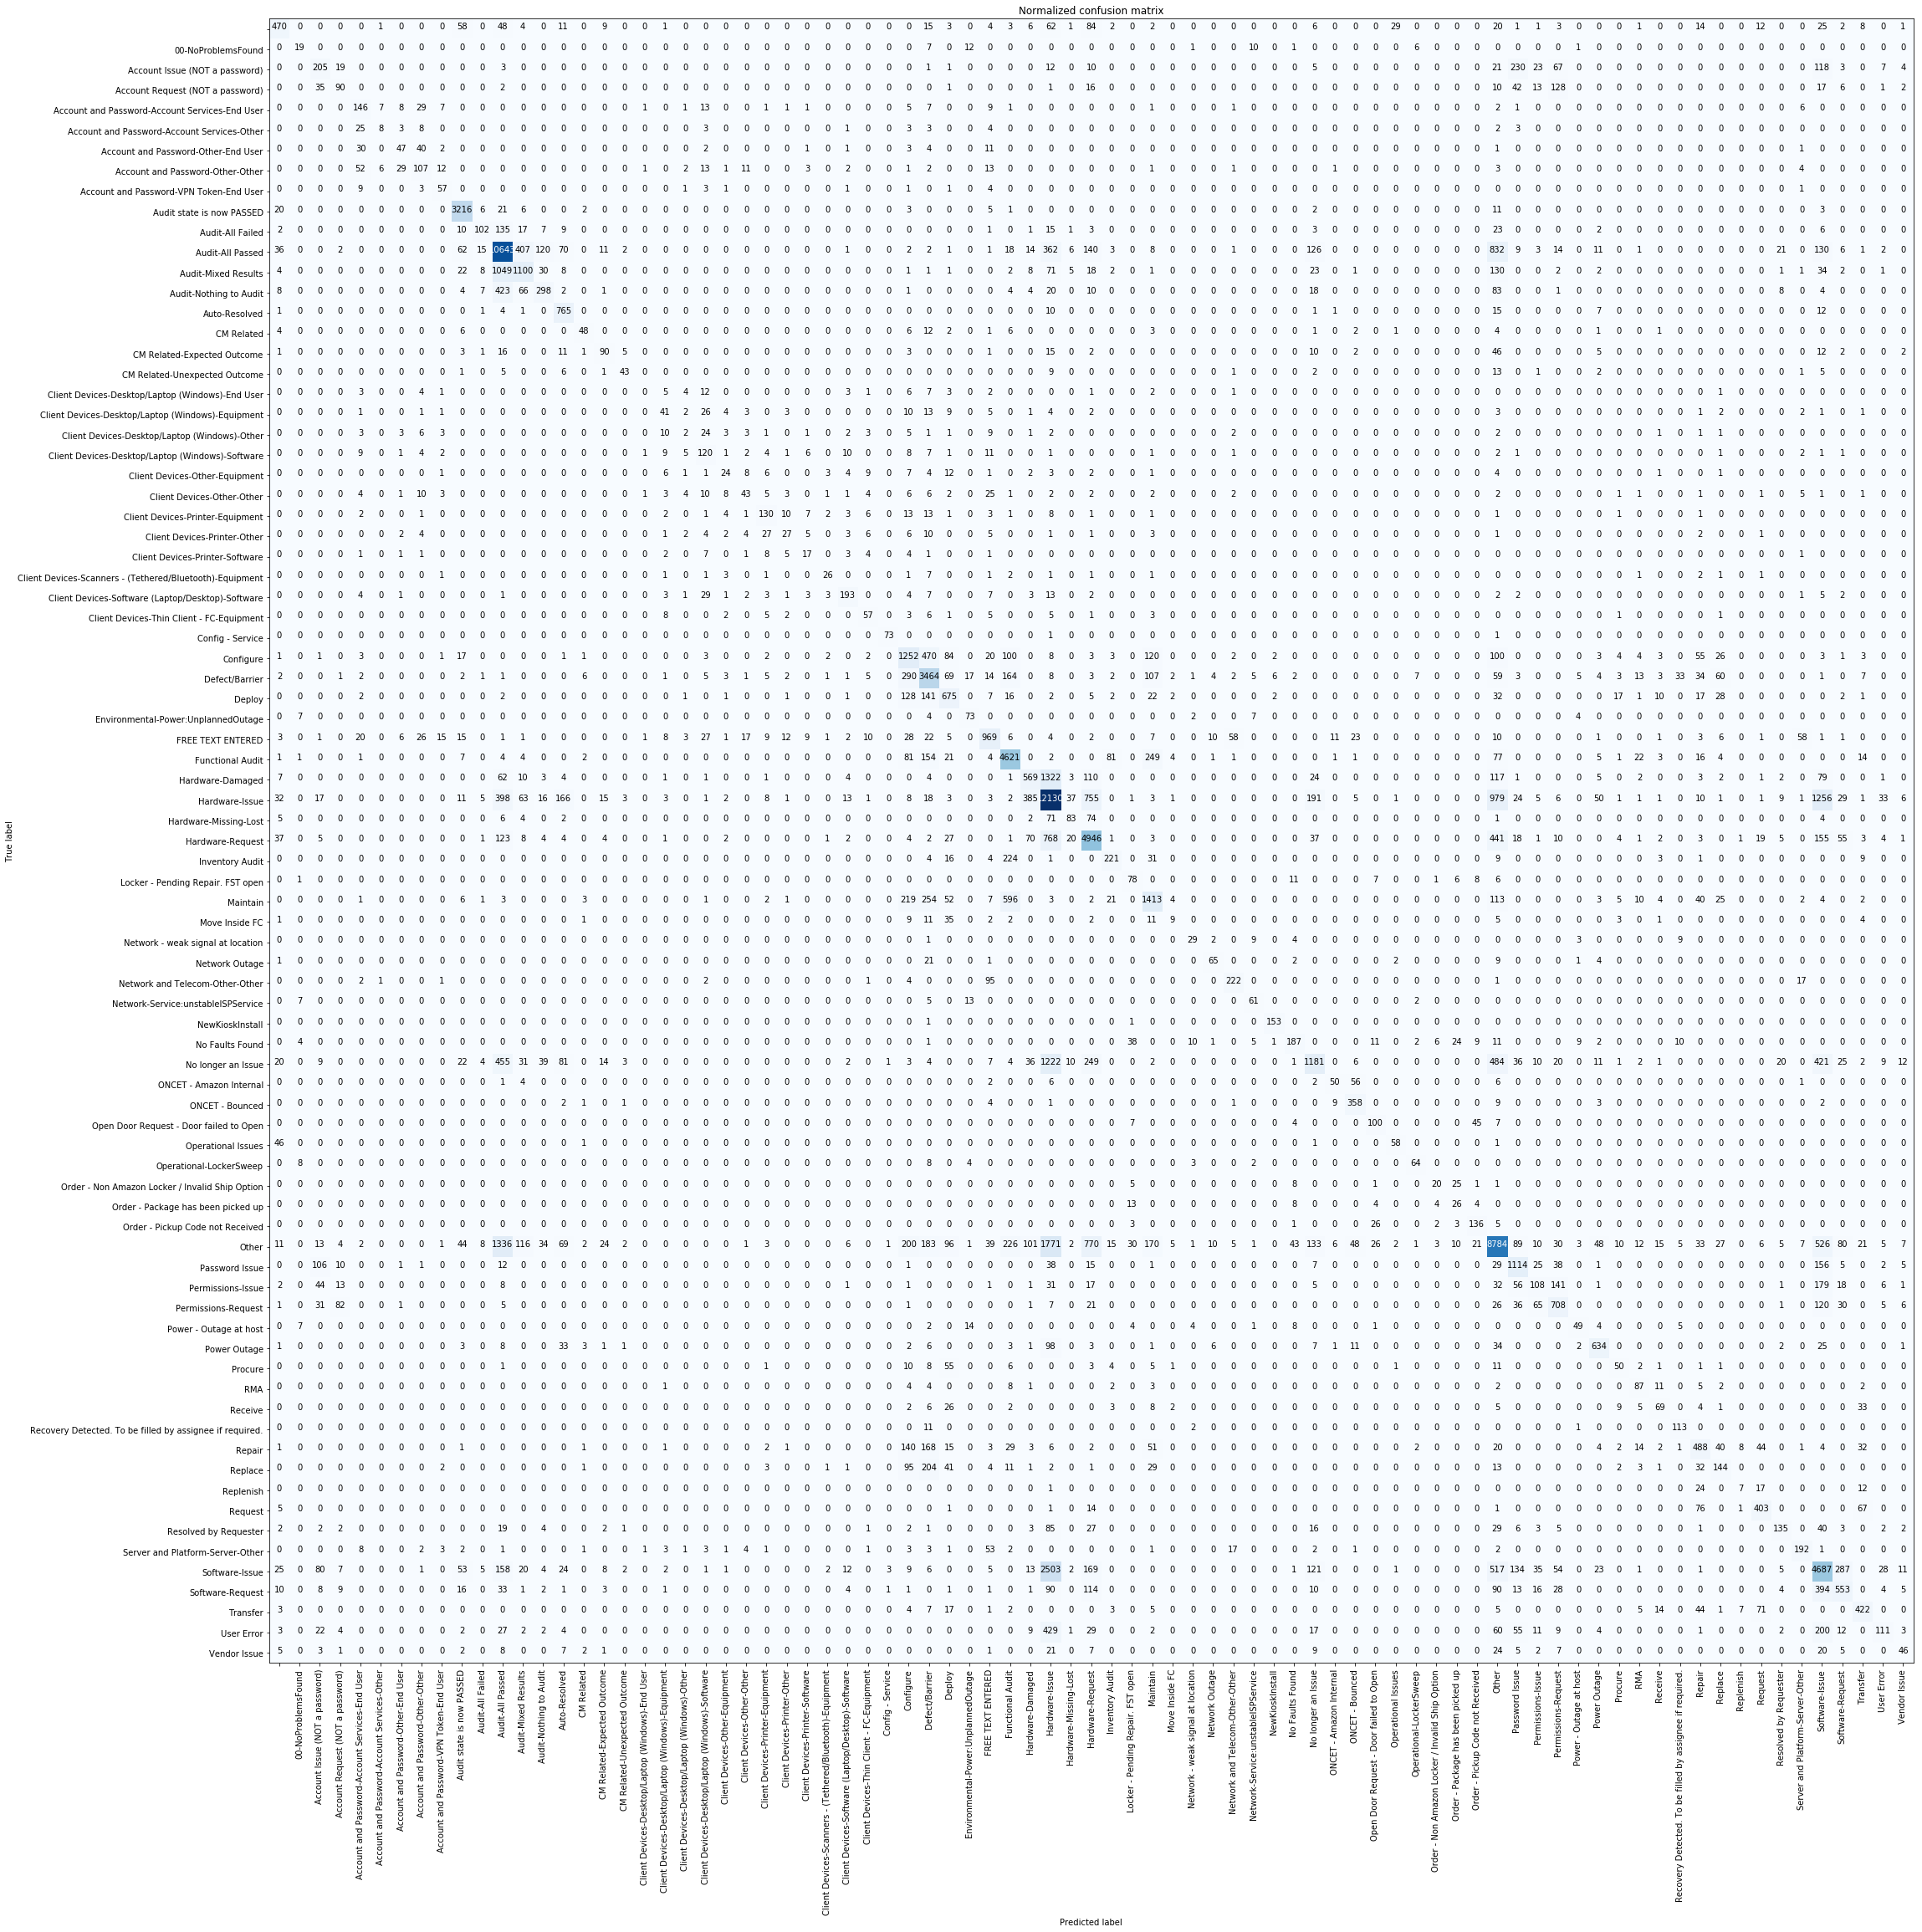

In [53]:
fig = plt.figure()
fig.set_size_inches(32, 32, forward=True)
plot_confusion_matrix(cnf_matrix, classes=data_test.classes, normalize=False, title='Normalized confusion matrix')